# AI/NLP Development Environment Setup

This document outlines the required Python packages for setting up an AI/NLP development environment that integrates various tools for document processing, Reddit API access, and Language Model interactions.

## Required Packages

- **chromadb**: Vector database for storing and managing embeddings
- **praw**: Python Reddit API Wrapper for accessing Reddit data
- **openai**: OpenAI's official client library
- **python-dotenv**: Environment variable management
- **langchain**: Framework for developing LLM-powered applications
- **langchain-openai**: LangChain integration with OpenAI models
- **langchain-text-splitters**: Text chunking and splitting utilities
- **langgraph**: Graph-based operations for LangChain


In [1]:
!pip install -q chromadb praw openai load-dotenv langchain langchain-openai langchain-text-splitters langgraph

# Environment Configuration Setup

This script handles the initialization of environment variables for OpenAI and Reddit API authentication. It uses the `python-dotenv` package to load environment variables from a `.env` file.

## Required Environment Variables

The following environment variables need to be set in your `.env` file:

- `OPENAI_API_KEY`: Your OpenAI API key
- `REDDIT_CLIENT_ID`: Your Reddit application client ID
- `REDDIT_CLIENT_SECRET`: Your Reddit application client secret
- `REDDIT_USER_AGENT`: Your Reddit API user agent string

## Configuration Variables

- `GENERATE_KNOWLEDGE`: Boolean flag (default: `False`) controlling knowledge generation functionality



In [2]:
import json
import os
import time
from typing import List, Dict, TypedDict

import chromadb
import praw
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from openai import OpenAI

# Marketing Research Agent

## Knowledge base generation pipeline

Loads environment variables and sets up configuration for OpenAI and Reddit API access. The `load_dotenv()` function imports variables from a `.env` file, while `os.getenv()` safely retrieves each value. `GENERATE_KNOWLEDGE` flag controls additional functionality.

In [3]:
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
CLIENT_ID = os.getenv('REDDIT_CLIENT_ID')
CLIENT_SECRET = os.getenv('REDDIT_CLIENT_SECRET')
USER_AGENT = os.getenv('REDDIT_USER_AGENT')

GENERATE_KNOWLEDGE = False

In [4]:
client = OpenAI()
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=CLIENT_SECRET,
                     user_agent=USER_AGENT)

# Reddit Search Phrase Generator

## Description
Generates relevant Reddit search phrases using OpenAI's GPT-3.5-turbo. The function takes a query string and returns a list of 5 Reddit-optimized search terms.

## Features
- Uses custom prompt engineering for Reddit-specific context
- Handles common Reddit terminology and naming patterns
- Includes error handling with fallback to original query
- Filters and cleans AI response to remove formatting characters
- Maintains 0.5 temperature for balanced creativity/relevance

## Parameters
- query: String (e.g., "project management software")

## Returns
List of 5 search phrases optimized for Reddit search

In [5]:
def get_relevant_topics(query: str) -> list:
    """
    Use OpenAI to generate relevant search phrases for a query
    """
    prompt = f"""
        You are a Reddit search expert who understands how Redditors discuss and search for topics.
        Given the query "{query}", generate 5 search phrases that will find the most relevant subreddits.

        Consider:
        - How Redditors naturally phrase their questions/discussions
        - Common abbreviations and terminology used on Reddit
        - Related tools, technologies, or concepts frequently discussed
        - Industry-specific subreddit naming patterns
        - Problem-focused search terms (as many discussions are about solving problems)

        For example, if query is "project management software":
        - projectmanagement (direct community)
        - asana vs trello (tool comparison commonly discussed)
        - agile tools (methodology + tools)
        - jira alternatives (tool alternative discussions)
        - remote team management (broader problem space)
        Return exactly 5 search phrases, one per line.
        Focus on phrases that would lead to active, relevant subreddit communities.
        Do not include any bullets, numbers, or prefixes.
    """

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{
                "role": "user",
                "content": prompt
            }],
            temperature=0.5,
            max_tokens=256
        )

        # Extract and clean phrases
        search_phrases = [
            phrase.strip()
            for phrase in response.choices[0].message.content.split('\n')
            if phrase.strip() and not phrase.startswith(('-', '*', '•', '1', '2', '3', '4', '5'))
        ]

        print(f"Generated search phrases: {search_phrases}")
        return search_phrases
    except Exception as e:
        print(f"Error generating topics: {e}")
        return [query]


# Subreddit Search Function

## Description
Performs multi-term subreddit search using PRAW (Reddit API wrapper). Takes a list of search terms and returns unique subreddits matching any term.

## Parameters
- search_terms: List of search phrases
- limit: Max subreddits per term (default 50)

## Returns
Deduplicated list of subreddit names
- Uses set for automatic deduplication
- Handles API errors gracefully
- Includes progress logging

In [6]:
def search_subreddits(search_terms, limit=50):
    """
    Search for subreddits matching multiple search terms.

    Args:
        search_terms (list): List of search queries to use
        limit (int): Maximum number of subreddits to return per search term

    Returns:
        list: List of unique subreddit names found across all search terms
    """
    print(f"Searching for subreddits matching {len(search_terms)} search terms...")
    subreddits = set()  # Using a set to avoid duplicates

    try:
        for term in search_terms:
            print(f"Searching with term: '{term}'...")
            term_subreddits = []
            for subreddit in reddit.subreddits.search(term, limit=limit):
                subreddits.add(subreddit.display_name)
                term_subreddits.append(subreddit.display_name)
            print(f"Found with '{term}': {term_subreddits}")
    except Exception as e:
        print(f"Error during subreddit search: {e}")

    return list(subreddits)  # Convert set back to list for consistency

# Subreddit Information Retriever

## Description
Fetches key information about a specific subreddit using PRAW, returning a dictionary of essential subreddit metadata.

## Parameters
- subreddit_name: String (name of the subreddit)

## Returns
Dictionary containing:
- name: Display name of subreddit
- title: Subreddit title
- subscribers: Number of subscribers
- public_description: Public description text

Returns None if retrieval fails

In [7]:
def get_subreddit_info(subreddit_name):
    """
    Retrieve information about a subreddit.
    """
    try:
        subreddit = reddit.subreddit(subreddit_name)
        return {
            'name': subreddit.display_name,
            'title': subreddit.title,
            'subscribers': subreddit.subscribers,
            'public_description': subreddit.public_description
        }
    except Exception as e:
        print(f"Error retrieving info for r/{subreddit_name}: {e}")
        return None

# Subreddit Post & Comment Scraper

## Description
Extracts comprehensive data from a subreddit's posts and their comments, including metadata and content. Includes rate limiting and error handling.

## Parameters
- subreddit_name: String (target subreddit)
- max_posts: Integer (maximum posts to fetch)
- max_comments: Integer, optional (comment fetch limit per post)

## Returns
List of dictionaries containing:
### Post Data
- id, title, author, score
- upvotes, downvotes
- num_comments, created_utc
- url, permalink, selftext
### Comment Data (per post)
- id, author, body, score
- upvotes, downvotes
- created_utc, parent_id
- link_id, permalink

## Features
- Rate limited (0.5s delay between posts)
- Handles comment tree expansion
- Includes error handling and logging

In [8]:
def get_subreddit_posts(subreddit_name: str, max_posts: int, max_comments: int = None):
    """
    Fetch all posts and comments from a subreddit, and extract problem-related sentences.
    """
    subreddit = reddit.subreddit(subreddit_name)
    posts_data = []

    print(f"Fetching posts from r/{subreddit_name}...")

    try:
        for post in subreddit.new(limit=max_posts):
            post_info = {
                'id': post.id,
                'title': post.title,
                'author': str(post.author),
                'score': post.score,
                'upvotes': post.ups,
                'downvotes': post.downs,
                'num_comments': post.num_comments,
                'created_utc': post.created_utc,
                'url': post.url,
                'permalink': post.permalink,
                'selftext': post.selftext,
                'comments': []
            }

            post.comments.replace_more(limit=max_comments)
            print(f"Fetching comments for post ID {post.id}...")
            for comment in post.comments.list():
                comment_info = {
                    'id': comment.id,
                    'author': str(comment.author),
                    'body': comment.body,
                    'score': comment.score,
                    'upvotes': comment.ups,
                    'downvotes': comment.downs,
                    'created_utc': comment.created_utc,
                    'parent_id': comment.parent_id,
                    'link_id': comment.link_id,
                    'permalink': comment.permalink
                }

                post_info['comments'].append(comment_info)

            posts_data.append(post_info)
            time.sleep(0.5)

    except Exception as e:
        print(f"Error fetching posts from r/{subreddit_name}: {e}")

    return posts_data

# ChromaDB Document Processor

## Description
Processes Reddit posts and comments data into embeddings and stores them in a ChromaDB collection. Handles text chunking, embedding generation, and batch processing for large datasets.

## Parameters
- posts_data: List[Dict] (Reddit posts and comments)
- collection_name: String (ChromaDB collection identifier)

## Features
- Uses OpenAI text-embedding-3-small model
- Recursive text splitting (500 char chunks, 50 overlap)
- Batch processing (500 documents per batch)
- Persistent storage in ChromaDB
- Handles both posts and comments

## Document Metadata
### Posts
- id, type, title, author
- url, created_utc

### Comments
- id, type, post_id, post_title
- author, parent_id, url, created_utc

## Returns
Integer count of total documents stored

In [9]:
def process_and_store_in_chroma(posts_data: List[Dict], collection_name: str):
    chroma_client = chromadb.PersistentClient(path="data/chroma_db")
    embeddings_client = OpenAIEmbeddings(
        model="text-embedding-3-small",
        openai_api_key=OPENAI_API_KEY
    )

    collection = chroma_client.get_or_create_collection(name=collection_name)

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=500,
        chunk_overlap=50
    )

    documents = []
    metadatas = []
    ids = []
    doc_id = 0

    print(f"Processing posts and comments for {collection_name}...")

    for post in posts_data:
        if post["selftext"]:
            chunks = text_splitter.split_text(post["selftext"]) if len(post["selftext"]) > 500 else [post["selftext"]]

            chunk_embeddings = embeddings_client.embed_documents(chunks)

            for chunk, embedding in zip(chunks, chunk_embeddings):
                documents.append(chunk)
                metadatas.append({
                    "id": post["id"],
                    "type": "post",
                    "title": post["title"],
                    "author": post["author"],
                    "url": post["url"],
                    "created_utc": str(post["created_utc"])
                })
                ids.append(f"doc_{doc_id}")
                doc_id += 1

        for comment in post.get("comments", []):
            if comment["body"]:
                chunks = text_splitter.split_text(comment["body"]) if len(comment["body"]) > 500 else [comment["body"]]

                chunk_embeddings = embeddings_client.embed_documents(chunks)

                for chunk, embedding in zip(chunks, chunk_embeddings):
                    documents.append(chunk)
                    metadatas.append({
                        "id": comment["id"],
                        "type": "comment",
                        "post_id": post["id"],
                        "post_title": post["title"],
                        "author": comment["author"],
                        "parent_id": comment["parent_id"],
                        "url": comment["url"],
                        "created_utc": str(comment["created_utc"])
                    })
                    ids.append(f"doc_{doc_id}")
                    doc_id += 1

        if len(documents) >= 500:
            embeddings = embeddings_client.embed_documents(documents)
            collection.add(
                documents=documents,
                embeddings=embeddings,
                metadatas=metadatas,
                ids=ids
            )
            print(f"Added batch of {len(documents)} documents to Chroma")
            documents = []
            metadatas = []
            ids = []

    # Add any remaining documents
    if documents:
        embeddings = embeddings_client.embed_documents(documents)
        collection.add(
            documents=documents,
            embeddings=embeddings,
            metadatas=metadatas,
            ids=ids
        )
        print(f"Added final batch of {len(documents)} documents to Chroma")

    return collection.count()

# Knowledge Base Generator

## Description
Orchestrates the full knowledge base generation pipeline, from Reddit search to ChromaDB storage. Combines subreddit search, data collection, and embedding storage functionalities.

## Parameters
- user_query: String (search topic)
- max_subreddits: Integer (subreddit limit)
- min_subscribers: Integer (minimum subscriber threshold)
- max_posts: Integer (posts per subreddit)
- max_comments: Integer, optional (comments per post)

## Process Flow
1. Generates search terms from query
2. Searches relevant subreddits
3. Filters by subscriber count
4. Collects posts and comments
5. Processes into ChromaDB collections

## Features
- Rate limiting between requests
- Progress logging
- Error handling per subreddit
- Creates separate collection per subreddit

In [10]:
def generate_knowledge_base(user_query: str, max_subreddits: int, min_subscribers: int, max_posts: int, max_comments: int = None):
    search_terms = get_relevant_topics(query=user_query)
    found_subreddits = search_subreddits(search_terms=search_terms, limit=max_subreddits)

    if not found_subreddits:
        print("No subreddits with enough subscribers found with the given query.")
        return

    print("\nRetrieving subreddit information...")
    subreddit_infos = []
    for subreddit_name in found_subreddits:
        info = get_subreddit_info(subreddit_name)
        if info:
            subreddit_infos.append(info)
        time.sleep(1)

    for info in subreddit_infos:
        if info['subscribers'] > min_subscribers:
            subreddit_name = info['name']
            print(f"\nProcessing r/{subreddit_name}...")

            posts = get_subreddit_posts(subreddit_name, max_posts, max_comments)

            try:
                collection_name = f"reddit_{subreddit_name.lower()}"
                doc_count = process_and_store_in_chroma(posts, collection_name)
                print(f"Processed and stored {doc_count} documents in Chroma collection '{collection_name}'")
            except Exception as e:
                print(f"Error processing and storing data in Chroma: {e}")

# Main Execution Block

## Description
Entry point for knowledge base generation, triggered by `GENERATE_KNOWLEDGE` flag. Handles user input collection and initiates the generation process.

## User Inputs
- query: Search topic string
- max_subreddits: Integer

## Fixed Parameters
- min_subscribers: 100,000
- max_posts: 100 per subreddit

## Usage
Set `GENERATE_KNOWLEDGE=True` in environment to activate interactive mode

In [11]:
if GENERATE_KNOWLEDGE:
    query = input("Enter the search query for subreddits: ")
    max_subreddits = int(input("Enter the number of subreddits to find: "))
    generate_knowledge_base(user_query=query, max_subreddits=max_subreddits, min_subscribers=100000, max_posts=100)

## Agent workflow

# Core LangChain & LangGraph Imports

Imports for OpenAI chat model integration (`ChatOpenAI`), prompt templating (`ChatPromptTemplate`), message types (`SystemMessage`, `AIMessage`, `HumanMessage`), and graph-based conversation flow components (`StateGraph`, `START`, `END`).

In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langgraph.graph import END, START, StateGraph

# ChatOpenAI Model Initialization

Initializes GPT-4 model with zero temperature (no randomness) for deterministic outputs.

In [13]:
llm = ChatOpenAI(model="gpt-4", temperature=0)

# query_chroma Function
- Queries Chroma DB with OpenAI embeddings to find similar content
- Input: query text, collection name, number of results (default=5)
- Uses text-embedding-3-small model and local persistent storage
- Returns matching documents from specified collection

In [14]:
def query_chroma(query_text: str, collection_name: str, n_results: int = 5):
    """
    Query the Chroma database for similar content.
    """
    chroma_client = chromadb.PersistentClient(path="data/chroma_db")
    embeddings_client = OpenAIEmbeddings(
        model="text-embedding-3-small",
        openai_api_key=OPENAI_API_KEY
    )

    collection = chroma_client.get_collection(name=collection_name)
    query_embedding = embeddings_client.embed_query(query_text)

    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )

    return results

# query_and_format_results Function
- Extends query_chroma by formatting results into organized dictionary
- Input: query text, collection name, result count (default=5)
- Returns: Dict with query info (search query, collection, total results) and matches (content, metadata, distance)
- Includes error handling with exception reporting

In [15]:
def query_and_format_results(query_text: str, collection_name: str, n_results: int = 5) -> Dict[dict, list]:
    """
    Query Chroma and return formatted results with all related information.

    Args:
        query_text (str): The search query
        collection_name (str): Name of the Chroma collection to search
        n_results (int): Number of results to return

    Returns:
        dict: Formatted results with query info and matched documents
    """
    try:
        # Get raw results from Chroma
        results = query_chroma(query_text, collection_name, n_results)

        # Format the results
        formatted_results = {
            "query_info": {
                "search_query": query_text,
                "collection": collection_name,
                "total_results": len(results['ids'][0])
            },
            "matches": []
        }

        # Process each result
        for i in range(len(results['ids'][0])):
            match = {
                "content": results['documents'][0][i],
                "metadata": results['metadatas'][0][i],
                "distance": results['distances'][0][i] if 'distances' in results else None
            }
            formatted_results["matches"].append(match)

        return formatted_results

    except Exception as e:
        print(f"Error querying database: {e}")
        return None


# augment_query Function
- Enhances search query using rules from JSON file
- Input: query text and optional JSON path (default='augment.json')
- Applies prefix/suffix rules from JSON to create multiple query variations
- Falls back to original query if JSON loading fails

In [16]:
def augment_query(query_text: str, query_file_path: str = 'augment.json'):
    """Augment query using json"""
    try:
        with open(query_file_path, 'r') as f:
            rules = json.load(f)
            return [f"{rule.get('prefix', '')} {query_text} {rule.get('suffix', '')}".strip()
                    for rule in rules.get('searches', [])]
    except:
        return [query_text]

# retrieve Function
- Retrieves matching documents from database using query augmentation
- Takes state dict with query (collection name currently hardcoded)
- Runs augmented variations of original query through query_and_format_results
- Returns dict containing search results and original query

In [17]:
def retrieve(state):
    query = state["query"]
    # TODO: Determine best collection
    # collection_name = state["collection"]
    collection_name = "reddit_digitalmarketing"

    augmented_queries = augment_query(query)

    for augmented_query in augmented_queries:
        #print(f"=== Search augmented query: {augmented_query} ===")
        results = query_and_format_results(augmented_query, collection_name)

    return {"results": results, "query": query}

# generate Function
- Formats search results into context for LLM response generation
- Uses source metadata to add context information (type, title for posts)
- Loads system prompt from generator_prompt.txt
- Creates chat template with context and query, invokes LLM
- Returns dict with results, query, and generated response

In [18]:
def generate(state):
    results = state["results"]
    query = state["query"]

    context_parts = []
    for match in results['matches']:
        metadata = match['metadata']
        source_info = f"Source: {metadata['type'].capitalize()}"
        if metadata['type'] == 'post':
            source_info += f" - Title: {metadata['title']}"

        context_parts.append(f"{source_info}\nContent: {match['content']}\n")

    context = "\n".join(context_parts)

    with open('generator_prompt.txt', 'r') as f:
        sys_prompt = f.read()

    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=sys_prompt),
        AIMessage(content=f"**Context:**\n{context}\n\n"),
        HumanMessage(content=f"**Question:** {query}")
    ])

    generator = prompt | llm
    response = generator.invoke({})

    return {"results": results, "query": query, "generation": response.content}

# AgentState TypedDict
- Defines structure for agent's conversation state
- Contains query (str), generation (str), and results (nested dict/list)
- Used for type checking and state management in conversation flow

In [19]:
class AgentState(TypedDict):
    query : str
    generation: str
    results : Dict[dict, list]

# LangGraph Workflow Setup
- Creates StateGraph with AgentState type
- Defines two processing nodes: retrieve and generate
- Sets linear flow: START → retrieve → generate → END
- Compiles graph for execution

In [20]:
workflow = StateGraph(AgentState)

workflow.add_node(retrieve, "retrieve")
workflow.add_node(generate, "generate")

workflow.add_edge(start_key=START, end_key="retrieve")
workflow.add_edge(start_key="retrieve", end_key="generate")
workflow.add_edge(start_key="generate", end_key=END)

graph = workflow.compile()

# Workflow Visualization Command
- Uses IPython to display workflow graph
- Renders Mermaid diagram showing node connections
- XRay mode reveals detailed graph structure
- Helps visualize START → retrieve → generate → END flow

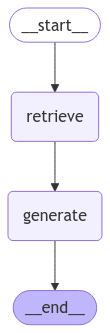

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Process query function
- Takes input dict with search query
- Streams graph execution output step by step
- Prints completion of each node (retrieve, generate)
- Shows generated response when available

In [22]:
def process_query(inputs):
    augmented_inputs = augment_query(inputs["query"])
    for augmented_query in augmented_inputs:
        augmented_input = {"query": augmented_query} 
        print ("Augmented query", augmented_query)
        for output in graph.stream(augmented_input):
            for key, value in output.items():
                print(f"Finished running: {key}:")
                if 'generation' in value:
                    print(value['generation'])

In [ ]:
inputs = {"query": "lead generation tools "}
process_query(inputs)

Augmented query Find popular tools for lead generation tools  and their main features
Finished running: retrieve:
Finished running: generate:
**Key Findings:**

1. The most frequently mentioned tools for lead generation and management include Monday CRM, LinkedIn’s SalesFlow, Warmly, ZoomInfo, Buffer, Hootsuite, Hubspot, ActiveCampaign, and Mailchimp.
2. Monday CRM and LinkedIn’s SalesFlow are popular for their CRM capabilities, while Warmly and ZoomInfo are known for their lead generation features.
3. Buffer and Hootsuite are recommended for organic growth and analytics, focusing on genuine engagement strategies.
4. Hubspot is recognized for its comprehensive lead gen and management features but is noted to be pricey. ActiveCampaign is suggested as a lower-cost alternative with automation and lead tracking capabilities.
5. Mailchimp is mentioned as a free tool up to a certain limit, presumably for email marketing and lead nurturing.

**Market Implications:**

1. There is a high demand